# Lecture 10:  Sparse matrices finale & Iterative methods

## Recap of the previous lecture
- Sparse matrix formats (COO, LIL, CSR)
- Matrix-by-vector product
- Gaussian elimination for sparse matrices and graphs

## Today lecture

- Gaussian elimination and graphs in more details
- Concept of **iterative methods** for linear systems
- Richardson iteration and its convergence, Chebyshev acceleration

## Gaussian elimination and graphs

Given symmetric matrix $A=A^T>0$ we calculate its Cholesky decomposition
<img src="gauss_elimination.png" /img>

## Gaussian elimination and graphs
In the symmetric case, $A = A^{\top} > 0$ the sparsity pattern of the matrix $L$: $A=LL^*$ is determined by operations on the graph of the matrix $A$.

The order of elimination is important, since we are adding new edges between neighbors.

## Illustration
The factorization is then a graph operation (on the right there is a sparsity of $L$ for different orderings)
<img src="gauss_elimination2.png" /img>

## Implemenation scheme

1. Preorder: replace A by $PAP^{\top}$ and $b$ by $Pb$ 
   Independent of numerics
2. Symbolic Factorization: build static data structure
 - Elimination tree
 - Nonzero counts
 - Supernodes (separate topic, we do not talk about it)
 - Nonzero structure of $L$
3. Numeric Factorization: $A = LL^{\top}$
 - Static data structure
 - Supernodes use BLAS3 to reduce memory traffic (separate topic)
4. Triangular Solves: solve $Ly = b$, then $L^{\top} x = y$ 

## Permutation $P$ selection
 
The selection of the permutation is done by looking at the graph.

## Banded reordering

Make the matrix more "banded" (Reverse Cuhill-McKee, Sloan, etc.). 

The idea is to try keeping entries closer to the diagonal. 

Works well for matrices coming from "quasi-one dimensional" PDEs.

## Minimal degree orderings

The idea is to eliminate rows and/or columns with fewer non-zeros, update fill-in and then repeat

Efficient implementation is an issue (adding/removing elements).

Current champion is "approximate minimal degree" by Amestoy, Davis, Duff.

It is **suboptimal** even for 2D problems

In practice, often wins for medium-sized problems.

## Nested dissection

### Nested dissection ordering

**Definition:** A **separator** in a graph $G$ is a set $S$ of vertices whose removal leaves at
least two connected components.

A nested dissection ordering for an $N$-vertex graph $G$ enumerates its
vertices from $1$ to $N$ as follows:
- Find a separator $S$, whose removal leaves connected components
$T_1$, $T_2$, $\ldots$, $T_k$
- Number the vertices of $S$ from $N − |S| + 1$ to $N$
- Recursively, number the vertices of each component: $T_1$ from $1$ to
$|T_1|$, $T_2$ from $|T_1| + 1$ to $|T_1| + |T_2|$, etc
- If a component is small enough, enumeration in this component is arbitrarily

It all boils down to finding good separators! 

### Nested dissection is "approximately optimal"

From theory, nested dissection gives you optimal complexity. 

Again, there are other methods that win for medium-sized problems.

They are based on **heuristic** matrix reordering techniques.

### Nested dissection summary

- Enumeration: find a separator, proceed recursively.
- In theory, optimal.
- In practice, beats others only for very large problems.

## Separators in practice

Computing separators is not a **trivial task**.

Graph partitioning heuristics has been an active research area for many years, often motivated by partitioning for parallel computation.

Existing approaches:

- Spectral partitioning (uses eigenvectors of Laplacian matrix of graph)
- Geometric partitioning (for meshes with specified vertex coordinates)
- Iterative-swapping (Kernighan-Lin, Fiduccia-Matheysses)
- Breadth-first search 

Many popular modern codes (e.g. Metis, Chaco) use multilevel iterative swapping.

## Iterative swapping

The "cost" of the separator is defined in a very natural way as the sum over edges:

$$T(A, B) = \sum_{e} \{ \mbox{weight}(e): \mbox{ $e$ connects $A$ and $B$} \}.$$

Given some initial partion $A$ and $B$, test some subsets $X\subset A$ and $Y\subset B$ of the same size, and if swapping decreases the cost function - swap them.

## Spectral bisection

The idea of spectral bisection goes back to Fiedler.

We need to split the vertices into two sets.

Consider +1/-1 labeling of vertices and the cost

$$E_c = \sum_{j} \sum_{i \in N(j)} (x_i - x_j)^2.$$

We need a balanced partition, thus 
$$\sum_i x_i =  0$$
and since we have +1/-1 labels, we have
$$\sum_i x^2_i = n.$$

We now relax the integer quadratic programming to the continuous quadratic programming

$$E_c = (Lx, x)\to \min_x$$
where $L$ is the **graph Laplacian**.

## Graph Laplacian
We introduce the **graph Laplacian** of the matrix, which is defined as as a symmetric matrix

as

$$L_{ii} = \mbox{degree of node $i$},$$

$$L_{ij} = -1, \mbox{if $i \ne j$  and there is an edge},$$

and $0$ otherwise.

- Rows of $L$ sum to zero, thus there is an eigenvalue $0$ (why?) and gives trivial eigenvector of all ones.
- Eigenvalues are non-negative.
- The number of connected components of a graph is the number of **zero eigenvalues**

## Fiedler vector
The solution to the minimization problem is given by the eigenvector (called Fiedler vector) corresponding  to the second smallest eigenvalue of the graph Laplacian. The sign $x_i$ indicates the partitioning.

In computations, we need to find out, how to find this second minimal eigenvalue -- we at least know about power method, but it finds the largest.

This is the main goal of the iterative methods for large-scale linear problems, and
can be achieved via few matrix-by-vector products.

## Iterative methods

If we want to achieve $\mathcal{O}(N)$ complexity, then direct solvers are not appropriate.

If we want to solve partial eigenproblem, the full eigendecomposition is too costly.

For both problems we will use iterative, Krylov subspace solvers, which treat the matrix as a **black-box** linear operator.

## Matrix as a black box

We have now an absolutely different view on a matrix: matrix is now a **linear operator**, that acts on a vector,  
and this action can be computed in $\mathcal{O}(N)$ operations.

**This is the only information** we know about the matrix: the <font color='red'> matrix-by-vector product (matvec) </font>

Can we solve linear systems using only matvecs?

Of course, we can multiply by the colums of the identity matrix, and recover the full matrix, but it is not what we need.

## Richardson iteration
The simplest idea is the **"simple iteration method"** or **Richardson iteration**.  


  $$Ax = f,$$
  $$\tau  (Ax - f) = 0,$$
   $$x - \tau (Ax - f) = x,$$
   $$x_{k+1} = x_k - \tau (Ax_k - f),$$
   
   where $\tau$ is the **iteration parameter**, which can be always chosen such that the method **converges**.

## Convergence of the Richardson method
Let $x_*$ be the solution; introduce an error $e_k = x_{k} - x_*$, then  

$$
     e_{k+1} = (I - \tau A) e_k,
$$

therefore if $\Vert I - \tau A \Vert < 1$ in any norm, the iteration converges. 

For symmetric positive definite case it is always possible to select $\tau$ such that the method converges.

What about the non-symmetric case?

## Optimal parameter choice
The optimal choice for $\tau$ for $A = A^* > 0$ is (prove it!)
$$
  \tau = \frac{2}{\lambda_{\min} + \lambda_{\max}}.
$$

where $\lambda_{\min}$ is the minimal eigenvalue, and $\lambda_{\max}$ is the maximal eigenvalue of the matrix $A$.

So, to find optimal parameter, we need to know the **bounds of the spectrum** of the matrix $A$,
and we can compute it by using **power method**.

## Connection to ODEs

The Richardson iteration has a deep connection to the Ordinary Differential Equations (ODE).


Consider a time-dependent problem ($A=A^*>0$)

$$\frac{dy}{dt} + A y = f, \quad y(0) = y_0.$$

Then $y(t) \rightarrow A^{-1} f$ as $t \rightarrow \infty$, and the **Euler scheme** reads

$$\frac{(y_{k+1} - y_k)}{\tau} = -A y_k + f.$$

which leads to the Richardson iteration
$$
    y_{k+1} = y_k - \tau(Ay_k -f)
$$

## Convergence speed and condition number

Even with the optimal parameter choice, the error at the next step satisfies

$$e_{k+1} \leq q e_k , \quad\rightarrow \quad e_k \leq c q^k,$$

where 

$$
   q = \frac{\lambda_{\max} - \lambda_{\min}}{\lambda_{\max} + \lambda_{\min}} = \frac{\mathrm{cond}(A) - 1}{\mathrm{cond}(A)+1},
$$

$$\mathrm{cond}(A) = \frac{\lambda_{\max}}{\lambda_{\min}} \quad \text{for} \quad A=A^*>0$$

is the condition number of $A$.

Let us do some demo...

((-0.081014052771004277+0j), (-3.9189859472289936+0j))

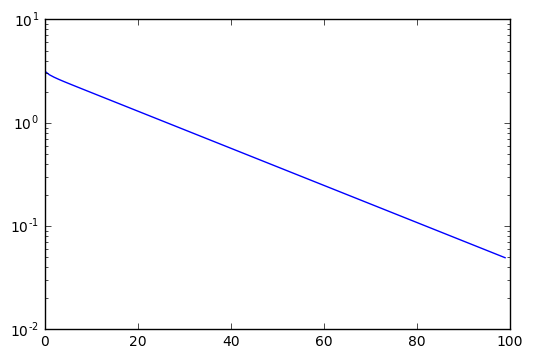

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sp
import scipy.sparse
import scipy.sparse.linalg as spla
import scipy
from scipy.sparse import csc_matrix
n = 10
ex = np.ones(n);
lp1 = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
rhs = np.ones(n)
ev1, vec = spla.eigs(lp1, k=2, which='LR')
ev2, vec = spla.eigs(lp1, k=2, which='SR')
lam_max = ev1[0]
lam_min = ev2[0]

tau_opt = 2.0/(lam_max + lam_min)

fig, ax = plt.subplots()
plt.close(fig)

niters = 100
x = np.zeros(n)
res_all = []
for i in xrange(niters):
    rr = lp1.dot(x) - rhs
    x = x - tau_opt * rr
    res_all.append(np.linalg.norm(rr))
#Convergence of an ordinary Richardson (with optimal parameter)
plt.semilogy(res_all)
lam_max, lam_min

## Condition number and convergence speed
Thus, for **ill-conditioned** matrices the error of the simple iteration method decays very slowly.<br>
This is another reason why **condition number** is so important:

* Besides  the bound on the error in the solution, it also gives an estimate of the number of iterations for the iterative methods.

Main questions for the iterative method is how to make the matrix **better conditioned**. <br>
The answer is <font color='red'> use preconditioners </font>. Preconditioners will be discussed in further lectures.

## Better iterative methods

But before preconditioners, we need to use **better iterative methods**. 

There is a whole **zoo** of iterative methods, but we need to know just few of them.

## Attempt 1: Different time steps

Suppose we **change** $\tau$ every step, i.e. 
$$
   x_{k+1} = x_k - \tau_k (A x_k - f).
$$
A possible choice of $\tau_k$ is such that it minimizes norm of the current residual (was considered in the pset 1). <br> 
This method is called **the steepest descent**.

Another way is to consider $$e_{k+1} = (I - \tau_k A) e_k = (I - \tau_k A) (I - \tau_{k-1} A)  e_{k-1} = \ldots = p(A) e_0, $$

where $p(A)$ is a **matrix polynomial** (simplest matrix function)  

$$
   p(A) = (I - \tau_k A) \ldots (I - \tau_0 A),
$$

and $p(0) = 1$.

## Optimal choice of time steps
The error is written as 

$$e_{k+1} = p(A) e_0, $$
and hence
$$\|e_{k+1}\| \leq \|p(A)\| \|e_0\|, $$
where $p(0) = 1$ and $p(A)$ is a **matrix polynomial**. 

To get better **error reduction**, we need to minimize

$$\Vert p(A) \Vert$$ over all possible polynomials $p(x)$ of degree $k+1$ such that $p(0)=1$. We will use $\|\cdot\|_2$.

##  Polynomials least deviating from zeros

Important special case: $A = A^* > 0$.

Then $A = U \Lambda U^*$, 

and 



$$\Vert p(A) \Vert_2 = \Vert U p(\Lambda) U^* \Vert_2 = \Vert p(\Lambda) \Vert_2 = \max_i |p(\lambda_i)| \leq 
\max_{\lambda_\min \leq \lambda \leq \lambda_\max} |p(\lambda)|.$$

Thus, we need to find a polynomial such that $p(0) = 1$, that has the least possible deviation from $0$ on $[\lambda_\min, \lambda_\max]$.

##  Polynomials least deviating from zeros (2)

We can do the affine transformation of the interval $[\lambda_\min, \lambda_\max]$ to the interval $[-1, 1]$.

The problem is then reduced to the problem of finding the **polynomial least deviating from zero** on an interval $[-1, 1]$ 

with some normalization constraint $p(c) = 1$, where $c$ is some point such that $c\not\in[\lambda_\min, \lambda_\max]$


## Exact solution: Chebyshev polynomials

The exact solution to this problem is given by the famous **Chebyshev polynomials** of the form

$$T_n(x) =  \cos (n \arccos x)$$

## What do you need to know about Chebyshev polynomials

1. This is a polynomial! (we can express $T_n$ from $T_{n-1}$ and $T_{n-2}$: $T_n(x) = 2x T_{n-1}(x) - T_{n-2}(x)$, $T_0(x)=1$, $T_1(x)=x$).

2. $|T_n(x)| \leq 1$ on $x \in [-1, 1]$.

3. It has $(n+1)$ **alternation points**, were the the maximal absolute value is achieved (this is the sufficient and necessary condition for the **optimality**) (Chebyshev alternance theorem, no proof here).

4. The **roots** are just  
$$n \arccos x_k = \frac{\pi}{2} + \pi k, \quad \rightarrow\quad x_k = \cos \frac{\pi(2k + 1)}{2n}$$

We can plot them...

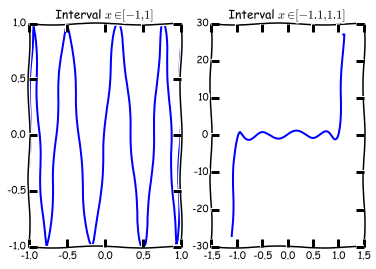

In [15]:
import numpy as np
import matplotlib.pyplot as plt
plt.xkcd()
%matplotlib inline
x1 = np.linspace(-1, 1, 128)
x2 = np.linspace(-1.1, 1.1, 128)
p = np.polynomial.Chebyshev((0, 0, 0, 0, 0, 0, 0, 0, 0, 1), (-1, 1)) #These are Chebyshev series, a proto of "chebfun system" in MATLAB
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(x1, p(x1))
ax1.set_title('Interval $x\in[-1, 1]$')
ax2.plot(x2, p(x2))
ax2.set_title('Interval $x\in[-1.1, 1.1]$')

## Convergence of the Chebyshev-accelerated Richardson iteration

Recall that roots of $p(x)$ are $1/\tau_i$ and that we additionally need to map back from $[-1,1]$ to $[\lambda_\min, \lambda_\max]$.
This results into 

$$\tau_i = \frac{2}{\lambda_\max + \lambda_\min - (\lambda_\max - \lambda_\min)x_i}, \quad i=1,\dots,k$$

The convergence (we only give the result without the proof) is now given by

$$
   e_{k+1} \leq C q^k, \quad q = \frac{\sqrt{\mathrm{cond}(A)}-1}{\sqrt{\mathrm{cond}(A)}+1},
$$
which is better than in the Richardson iteration.

## Beyond Chebyshev

We have made an important assumption about the spectrum: it is contained within an interval over the real line (and we need to know the bounds)

If the spectrum is contained within **two intervals**, and we know the bounds, we can also put the optimization problem 

for the **optimal polynomial**.



## Spectrum of the matrix contained in multiple segments

For the case of **two segments** the best polynomial is given by **Zolotarev polynomials** (expressed in terms of elliptic functions)

For the case of **more than two segments** the best polynomial can be expressed in terms of **hyperelliptic functions**

## How can we make it better

The implementation of the Chebyshev acceleration requires the knowledge of the spectrum.

It only stores the **previous vector** $x_k$ and computes the new correction vector

$$r_k = A x_k - f.$$

It belongs to the class of **two-term** iterative methods.

It appears that if we **store more vectors**, then we can go without the spectrum estimation (and better convergence in practice)!

## Crucial point: Krylov subspace

The Chebyshev method produces the approximation of the form

$$x_{m+1} = p(A) f,$$

i.e. it lies in the **Krylov subspace** of the matrix  which is defined as

$$
   K_m(A, f) = \mathrm{Span}(f, Af, A^2 f, \ldots, A^{m-1}f )
$$

The most natural approach then is to find the vector in this **linear subspace** that minimizes 
certain **norm of the error**

## Take home message

- Finalized Gaussian elimination for sparse matrices and its connection to graphs
- Introduced two iterative methods: Richardson iteration and Chebyshev acceleration

## Next lecture

- Several Krylov iterative methods: conjugate gradient (CG), GMRES.
- Lanczos and Arnoldi orthogonalization of Krylov subspaces, optimality result for Krylov subspaces
- Convergence estimates

# Questions?

In [16]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()